In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from geopy import distance

In [2]:
df = pd.read_csv("/Users/kangchieh/Project/divvy_bike/data/divvy_202207-202306/csv/202207-divvy-tripdata.csv")
df.head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,954144C2F67B1932,classic_bike,2022-07-05 08:12:47,2022-07-05 08:24:32,Ashland Ave & Blackhawk St,13224,Kingsbury St & Kinzie St,KA1503000043,41.907066,-87.667252,41.889177,-87.638506,member
1,292E027607D218B6,classic_bike,2022-07-26 12:53:38,2022-07-26 12:55:31,Buckingham Fountain (Temp),15541,Michigan Ave & 8th St,623,41.869621,-87.623981,41.872773,-87.623981,casual
2,57765852588AD6E0,classic_bike,2022-07-03 13:58:49,2022-07-03 14:06:32,Buckingham Fountain (Temp),15541,Michigan Ave & 8th St,623,41.869621,-87.623981,41.872773,-87.623981,casual
3,B5B6BE44314590E6,classic_bike,2022-07-31 17:44:21,2022-07-31 18:42:50,Buckingham Fountain (Temp),15541,Woodlawn Ave & 55th St,TA1307000164,41.869621,-87.623981,41.795264,-87.596471,casual
4,A4C331F2A00E79E0,classic_bike,2022-07-13 19:49:06,2022-07-13 20:15:24,Wabash Ave & Grand Ave,TA1307000117,Sheffield Ave & Wellington Ave,TA1307000052,41.891466,-87.626761,41.936253,-87.652662,member
5,579D73BE2ED880B3,electric_bike,2022-07-01 17:04:35,2022-07-01 17:13:18,Desplaines St & Randolph St,15535,Clinton St & Roosevelt Rd,WL-008,41.884614,-87.644564,41.867118,-87.641088,member
6,EFE518CCEE333669,classic_bike,2022-07-18 18:11:01,2022-07-18 18:22:30,Marquette Ave & 89th St,20239,East End Ave & 87th St,20231,41.733669,-87.558342,41.736815,-87.582801,member
7,315FEBB7B3F6D2EA,classic_bike,2022-07-28 20:38:18,2022-07-28 21:09:11,Wabash Ave & Grand Ave,TA1307000117,Dearborn Pkwy & Delaware Pl,TA1307000128,41.891466,-87.626761,41.898969,-87.629912,casual
8,EE3C4A1E66766B56,classic_bike,2022-07-10 22:55:59,2022-07-10 23:01:32,Wabash Ave & Grand Ave,TA1307000117,Dearborn Pkwy & Delaware Pl,TA1307000128,41.891466,-87.626761,41.898969,-87.629912,member
9,1EE6C93A547A187C,electric_bike,2022-07-10 09:35:58,2022-07-10 09:47:25,Ashland Ave & Blackhawk St,13224,Orleans St & Merchandise Mart Plaza,TA1305000022,41.907093,-87.667247,41.888243,-87.636390,member


In [32]:
def calculate_distance(x):
    if not x[["start_lat","start_lng","end_lat","end_lng"]].isnull().any():
        return distance.distance((x['start_lat'], x['start_lng']), (x['end_lat'], x['end_lng'])).km
    else:
        return np.nan
        
df['distance'] = df.apply(lambda x: calculate_distance(x), axis=1)

In [92]:
df["started_at"] = pd.to_datetime(df["started_at"], errors='coerce')
df["ended_at"] = pd.to_datetime(df["ended_at"], errors='coerce')
df['ride_duration'] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60

In [93]:
def is_weekend(date):
    return date.dayofweek >= 5 # 5 is saturday 6 is sunday

df['weekend'] = df['started_at'].apply(is_weekend).astype(int)

In [68]:
df.groupby('member_casual')['distance'].median()

member_casual
casual    1.691020
member    1.659866
Name: distance, dtype: float64

array([<AxesSubplot:title={'center':'casual'}>,
       <AxesSubplot:title={'center':'member'}>], dtype=object)

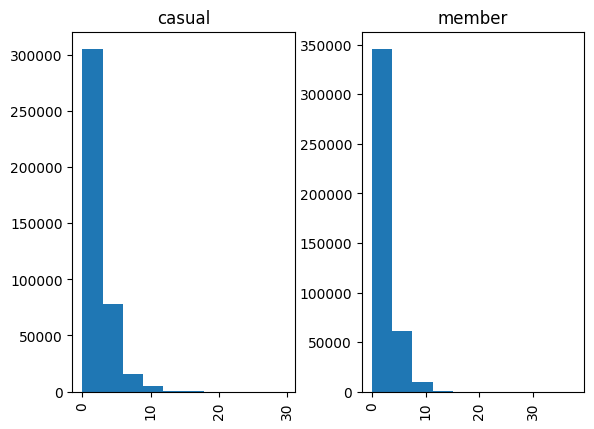

In [66]:
df.hist('distance', by='member_casual')

TypeError: The DTypes <class 'numpy.dtype[float64]'> and <class 'numpy.dtype[timedelta64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

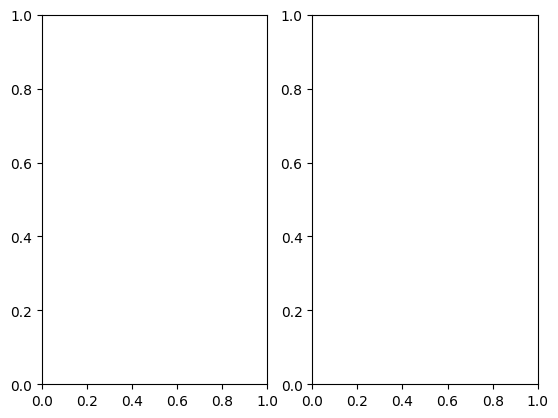

In [70]:
df.hist('ride_duration', by='member_casual')

In [78]:
df1 = df.copy()

In [79]:
df1['ride_duration'] = df1['ride_duration'].dt.total_seconds() / 60

In [80]:
df1.loc[0, 'ride_duration']

11.75

In [90]:
df.groupby('member_casual')['ride_duration'].mean()

member_casual
casual   0 days 00:29:16.685269236
member   0 days 00:13:43.100408927
Name: ride_duration, dtype: timedelta64[ns]

In [91]:
df['member_casual'].value_counts()

member    417433
casual    406055
Name: member_casual, dtype: int64

In [98]:
df.groupby('member_casual')['weekend'].value_counts()

member_casual  weekend
casual         0          232574
               1          173481
member         0          289784
               1          127649
Name: weekend, dtype: int64

In [99]:
23/41

0.5609756097560976

In [100]:
28/40

0.7

In [104]:
df.groupby(['member_casual', 'weekend']).size() / df.groupby('member_casual').size() * 100

member_casual  weekend
casual         0          57.276477
               1          42.723523
member         0          69.420482
               1          30.579518
dtype: float64